In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sn
import numpy as np
import os
import salem
import pyproj
from netCDF4 import Dataset
sn.set_context('notebook')

C:\Anaconda2\lib\site-packages\xarray\core\formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


# DOMQUA climate data processing

For full details of the processing required, see Leah's Word document here:

K:\Prosjekter\Klima\O-13382 DomQua HWI\8 Future DOC\Gridded_Data_Tasks.docx

The main aims are as follows:

 * For historic (E-Obs) and two future (RCP45 and RCP85) sets of climate data, calculate **average annual temperature (C)** and **total summer (JAS) precipitation (mm)**. <br><br>
 
 * Reproject, clip and resample the data to match the Fenoscabdian grid used in the [previous DOMQUA spatial interpolation work](http://nbviewer.jupyter.org/github/JamesSample/spatial_interpolation/blob/master/spatial_interpolation_2.ipynb). <br><br>
 
 * Make the ouputs available as annual netCDF files and as GeoTiffs (the latter for easy processing within ArcGIS).

## 1. Data locations

 * The future climate data is located here (for RCP45):
 
 D:\Data\Climate\CMIP5\GFDL-ESM2M\Atmos\RCP45\all_vars
 
 and here (for RCP85):
 
 D:\Data\Climate\CMIP5\GFDL-ESM2M\Atmos\RCP85\all_vars
 
 Note that I've placed the files for temperature and precipitation in the same folder in each case. <br><br>
 
 * The historic datasets are located here:
 
 D:\Data\Climate\E-OBS\Data
 
## 2. Output projection parameters

The easiest way to get the desired projection parameters is to read them from one of the previous output grids (from the spatial interpolation work).

In [2]:
# Snap raster defining extent and cell size for desired output
tif_path = r'D:\Data\Climate\Output_Grid\chem_TOC_idw_n24_p1_clip.tif'
gtif = salem.open_xr_dataset(tif_path)
gtif

<xarray.Dataset>
Dimensions:  (x: 64, y: 77)
Coordinates:
  * y        (y) float64 2e+06 1.975e+06 1.95e+06 1.925e+06 1.9e+06 ...
  * x        (x) float64 3.25e+05 3.5e+05 3.75e+05 4e+05 4.25e+05 4.5e+05 ...
Data variables:
    data     (y, x) float32 2.18604 2.15718 1.92866 1.88092 1.87324 1.87352 ...
Attributes:
    pyproj_srs: +lon_0=15 +ellps=WGS84 +y_0=1000000 +no_defs=True +proj=aea +x_0=1000000 +units=m +lat_2=73 +lat_1=53 +lat_0=63 

Looking at the x and y cor-ordinates here, Salem is reading grid values as the upper left corner of each grid cell. For the regridding, it makes more sense to specify the cell centres, so the first step is to shift the co-ordinates by half a cell (= 12500 m). The resulting dataset defines the points at which we want to interpolate the data.

In [3]:
# Adjust gtif co-ords to cell centres
gtif['x'] = gtif['x'] + 12500
gtif['y'] = gtif['y'] - 12500
gtif

<xarray.Dataset>
Dimensions:  (x: 64, y: 77)
Coordinates:
  * y        (y) float64 1.988e+06 1.962e+06 1.938e+06 1.912e+06 1.888e+06 ...
  * x        (x) float64 3.375e+05 3.625e+05 3.875e+05 4.125e+05 4.375e+05 ...
Data variables:
    data     (y, x) float32 2.18604 2.15718 1.92866 1.88092 1.87324 1.87352 ...
Attributes:
    pyproj_srs: +lon_0=15 +ellps=WGS84 +y_0=1000000 +no_defs=True +proj=aea +x_0=1000000 +units=m +lat_2=73 +lat_1=53 +lat_0=63 

## 3. Future climate data

### 3.1. RCP45

#### 3.1.1. Dataset properties

In [4]:
# Read all the RC45 files and combine into a single dataset
nc_path = r'D:\Data\Climate\CMIP5\GFDL-ESM2M\Atmos\RCP45\all_vars\*.nc'
ds_45 = xr.open_mfdataset(nc_path)

ds_45

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 90, lon: 144, time: 1140)
Coordinates:
  * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 ...
  * lon         (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 ...
  * bnds        (bnds) float64 1.0 2.0
  * time        (time) datetime64[ns] 2006-01-16T12:00:00 2006-02-15 ...
    height      float64 2.0
Data variables:
    average_DT  (time) timedelta64[ns] 31 days 28 days 31 days 30 days ...
    average_T1  (time) datetime64[ns] 2006-01-01 2006-02-01 2006-03-01 ...
    average_T2  (time) datetime64[ns] 2006-02-01 2006-03-01 2006-04-01 ...
    pr          (time, lat, lon) float64 7.013e-06 7.009e-06 7.006e-06 ...
    time_bnds   (time, bnds) datetime64[ns] 2006-01-01 2006-02-01 2006-02-01 ...
    lat_bnds    (time, lat, bnds) float64 -90.0 -88.99 -88.99 -86.97 -86.97 ...
    lon_bnds    (time, lon, bnds) float64 0.0 2.5 2.5 5.0 5.0 7.5 7.5 10.0 ...
    tas         (time, lat, lon) float64 251.2 251.2 251.2 251.

In [5]:
ds_45['pr']

<xarray.DataArray 'pr' (time: 1140, lat: 90, lon: 144)>
dask.array<concate..., shape=(1140, 90, 144), dtype=float64, chunksize=(60, 90, 144)>
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
  * time     (time) datetime64[ns] 2006-01-16T12:00:00 2006-02-15 ...
    height   float64 2.0
Attributes:
    long_name: Precipitation
    units: kg m-2 s-1
    cell_methods: time: mean
    interp_method: conserve_order1
    standard_name: precipitation_flux
    original_units: kg/m2/s
    original_name: precip
    cell_measures: area: areacella
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation areacella: areacella_fx_GFDL-ESM2M_rcp45_r0i0p0.nc

In [6]:
ds_45['tas']

<xarray.DataArray 'tas' (time: 1140, lat: 90, lon: 144)>
dask.array<concate..., shape=(1140, 90, 144), dtype=float64, chunksize=(60, 90, 144)>
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
  * time     (time) datetime64[ns] 2006-01-16T12:00:00 2006-02-15 ...
    height   float64 2.0
Attributes:
    long_name: Near-Surface Air Temperature
    units: K
    valid_range: [ 100.  400.]
    cell_methods: time: mean
    standard_name: air_temperature
    original_units: deg_k
    original_name: t_ref
    cell_measures: area: areacella
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation areacella: areacella_fx_GFDL-ESM2M_rcp45_r0i0p0.nc

Note that **precipitation is in kg/m2/s (=mm/s**) and that **temperature is in Kelvin**. The data have a monthly time step and 1140 steps, beginning in January 2006 and ending in December 2100 (as expected).

#### 3.1.2. Resampling

In [7]:
# Convert from K to C
ds_45t = ds_45['tas'] - 273.15

# Calculate mean annual temperature
ds_45t = ds_45t.resample(freq='A',
                         dim='time', 
                         how='mean')

# Convert units from kg/m2/s to mm/day
ds_45p = ds_45['pr']*60*60*24

# Calculate quarterly total pptn for quarters ending in Sept
ds_45p = ds_45p.resample(freq='Q-MAR',
                         dim='time', 
                         how='sum')

# Select just the grids where season is JAS (i.e. month = 9)
ds_45p = ds_45p[ds_45p['time.month']==9]

# Resample this to annual (as we no longer need the month info)
# NB. This will still give just the summer totals in each year
ds_45p = ds_45p.resample(freq='A',
                         dim='time', 
                         how='mean')

# Combine temp and pptn
ds_45_agg = xr.merge([ds_45t, ds_45p])

ds_45_agg

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, time: 95)
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...
Data variables:
    tas      (time, lat, lon) float64 -43.33 -43.33 -43.33 -43.33 -43.32 ...
    pr       (time, lat, lon) float64 0.4189 0.4189 0.4189 0.4189 0.4189 ...

#### 3.1.3. Reprojecting, clipping and resampling

From here it should be easy to reproject the data with Salem, but the package seems unable to correctly infer the projection parameters for the global climate datasets.

In [8]:
# Print proj pars guessed by Salem
grid = ds_45_agg.salem.grid

print grid.proj.srs
print grid.extent

+units=m +datum=WGS84 +proj=latlong 
[2.2204460492503131e-16, 359.99999999999994, -90.252808988764059, 46.264044943821403]


These values are incorrect. I think part of the probelm may be a dateline issue (?), but I haven't investigated in detail. If the area of interest spans a discontinuity in longitudes, then I think there might be problems, but in our case it doesn't matter as the whole of Fenoscandia lies east of the Greenwich meridian.

The next step is therefore to extract a sub-region to approximate our area of interest. In principle, Salem offers slicing based on geographic co-ordinates, but because the projection has been inferred incorrectly this won't work. Instead, we need to manually subset the data using xarray and then pass the clipped dataset to Salem. Once the data has been clipped down from a global extent, singularities and discontinuities in the projection parameters become less of a problem, and Salem seems to correctly infer the parameters.

In [9]:
# Function for manually subsetting xarray datasets
def geo_idx(bb, lat_array, lon_array):
    """ Get array indices for specified lat/long bounding box.
        Adapted from here:
        http://stackoverflow.com/questions/33789379/
        netcdf-and-python-finding-the-closest-lon-lat-index-given-actual-lon-lat-values
    
        Assumes there are no discontinuities in the co-ordinate arrays.
        
    Args:
        bb        Nested tuple specifying bounding box in decimal degrees 
                  ((llx, lly), (urx, ury))
        lat_array Array of lat values from netCDF
        lon_array Array of lon values from netCDF
    """
    # Extract co-ords
    x0, y0 = bb[0]
    x1, y1 = bb[1]
    
    # Get array indices
    x0_idx = int((np.abs(lon_array - x0)).argmin())
    y0_idx = int((np.abs(lat_array - y0)).argmin())
    x1_idx = int((np.abs(lon_array - x1)).argmin())
    y1_idx = int((np.abs(lat_array - y1)).argmin())
    
    return x0_idx, y0_idx, x1_idx, y1_idx

In [10]:
# Get indices for bounding box
x0, y0, x1, y1 = geo_idx(((0, 40), (40, 80)), 
                         ds_45_agg['lat'],
                         ds_45_agg['lon'])

# Clip xarray data
ds_45_agg = ds_45_agg.isel(lat=slice(y0, y1), 
                           lon=slice(x0, x1))

ds_45_agg

<xarray.Dataset>
Dimensions:  (lat: 20, lon: 15, time: 95)
Coordinates:
  * lat      (lat) float64 39.44 41.46 43.48 45.51 47.53 49.55 51.57 53.6 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...
Data variables:
    tas      (time, lat, lon) float64 16.59 17.01 16.92 16.97 16.86 17.53 ...
    pr       (time, lat, lon) float64 3.673 2.742 2.765 2.933 3.124 3.594 ...

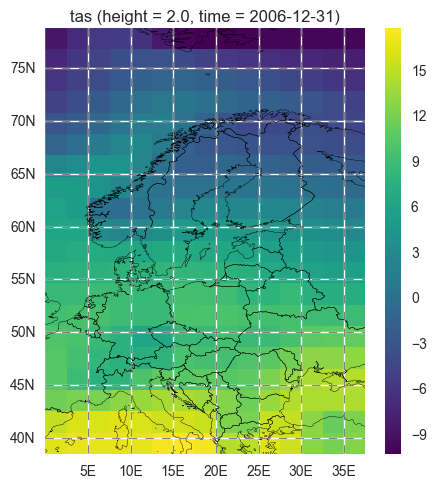

In [11]:
# Simple map showing clipped extent for temp in 2006
ds_45_agg['tas'][0].salem.quick_map()

We can now reproject and clip this grid to the desired output.

It's worth describing what's happening here:

 * We have a clipped xarray dataset consisting of latitude and longitude co-ordinates using the WGS84 datum. <br><br>
 
 * We have a second xarray dataset created from one of the GeoTiffs produced during earlier work on spatial interpolation. This dataset usies a custom projection defined for Fenoscandia. 
 
Both datasets are "gridded", but in reality they just consist of sets of point co-ordinates: `(lon, lat, tas, pr)`. To build a raster, we simply assume that each set of co-ordinates is representative of a square region (i.e. a pixel/grid cell) centred on each point. To perfrom the reprojection we need to do two things:

 1. Convert all the point co-ordinates in the lat/lon data to point co-ordinates in the projected Fenoscandian co-ordinate system. This will proudce an irregularly spaced grid of points. <br><br>
 
 2. Interpolate the irregular grid from (1) to estimate values for each parameter at the points defined in the GeoTiff (i.e. the new cell centres). There are several methods available for this interpolation step (`nearest`, `linear` and `spline`).
 
Initially I will use `interp='nearest`, as this should preserve the data and make things easier to check. If everything looks OK, I'll repeat the process using either `linear` or `spline`, as these will likely give better results.

In [12]:
# Reproject (and clip) to desired output
ds_45_proj = gtif.salem.transform(ds_45_agg, interp='nearest')
ds_45_proj

<xarray.Dataset>
Dimensions:  (time: 95, x: 64, y: 77)
Coordinates:
  * y        (y) float64 1.988e+06 1.962e+06 1.938e+06 1.912e+06 1.888e+06 ...
  * x        (x) float64 3.375e+05 3.625e+05 3.875e+05 4.125e+05 4.375e+05 ...
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...
    height   float64 2.0
Data variables:
    tas      (time, y, x) float64 nan nan nan nan nan nan -4.669 -4.669 ...
    pr       (time, y, x) float64 nan nan nan nan nan nan 4.405 4.405 4.405 ...
Attributes:
    pyproj_srs: +lon_0=15 +ellps=WGS84 +y_0=1000000 +no_defs=True +proj=aea +x_0=1000000 +units=m +lat_2=73 +lat_1=53 +lat_0=63 

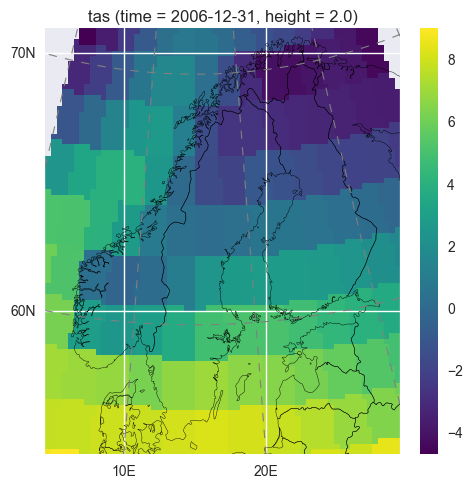

In [13]:
# Simple map of reprojected data
ds_45_proj['tas'][0].salem.quick_map()

#### 3.1.4. Checking

Most of the processing is now complete, but it's worth checking that the results are sensible. As a test, I'll go back to the raw data and extract the raw monthly time series for a particular location (e.g. Oslo, lat ~ 60, lon ~ 11). I'll then process this using pandas (which I'm familiar with) to calculate average annual tmeperature and total summer precipitation. I'll then extract a time series for the same location from my processed and reprojected xarray dataset (`ds_45_proj`). If all is well, these two workflows should give the same results.

In [14]:
# Get raw series

# Get raw temp series original netCDFs
ds_raw_t = ds_45['tas'].sel_points(lon=[11],
                                   lat=[60],
                                   method='nearest')

# Convert to dataframe
df_t = ds_raw_t.to_dataframe().reset_index()
df_t.index = df_t['time']
df_t = df_t[['tas']]

# Convert units
df_t['tas'] = df_t['tas'] - 273.15

# Resample to annual averages
df_t = df_t.resample('A').mean()

df_t.head()

# Get raw pptn series original netCDFs
ds_raw_p = ds_45['pr'].sel_points(lon=[11],
                                  lat=[60],
                                  method='nearest')

# Convert to dataframe
df_p = ds_raw_p.to_dataframe().reset_index()
df_p.index = df_p['time']
df_p = df_p[['pr']]

# Convert units
df_p['pr'] = df_p['pr']*60*60*24

# Calculate quarterly total pptn for quarters ending in Sept
df_p = df_p.resample('Q-MAR').sum()

# Select just the grids where season is JAS (i.e. month = 9)
df_p = df_p[df_p.index.month==9]

# Resample this to annual (as we no longer need the month info)
# NB. This will still give just the summer totals in each year
df_p = df_p.resample('A').mean()

# Combine
df_raw = df_t.join(df_p)

df_raw.head()

,tas,pr
time,,
2006-12-31,2.979250,15.188549
2007-12-31,4.279446,12.212862
2008-12-31,3.151412,9.523927
2009-12-31,3.121942,8.558025
2010-12-31,1.511112,7.629347


In [15]:
# Get projected series

# Convert lat/lon co-ords to projected co-ord system
p1 = pyproj.Proj(init='epsg:4326')
p2 = pyproj.Proj(ds_45_proj.salem.grid.proj.srs)
x, y = pyproj.transform(p1, p2, 11, 60)
print 'Projected co-ords: %.3f %.3f' % (x, y)

# Get the temp series from the processed ds
ds_proj_t = ds_45_proj['tas'].sel_points(x=[x],
                                         y=[y],
                                         method='nearest')

# Convert to dataframe
df_t = ds_proj_t.to_dataframe().reset_index()
df_t.index = df_t['time']
df_t = df_t[['tas']]

# Resample to annual averages
df_t = df_t.resample('A').mean()

# Get the pptn series from the processed ds
ds_proj_p = ds_45_proj['pr'].sel_points(x=[x],
                                        y=[y],
                                        method='nearest')

# Convert to dataframe
df_p = ds_proj_p.to_dataframe().reset_index()
df_p.index = df_p['time']
df_p = df_p[['pr']]

# Combine
df_proj = df_t.join(df_p)

df_proj.head()

Projected co-ords: 779666.199 667817.578


,tas,pr
time,,
2006-12-31,2.979250,15.188549
2007-12-31,4.279446,12.212862
2008-12-31,3.151412,9.523927
2009-12-31,3.121942,8.558025
2010-12-31,1.511112,7.629347


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000193489E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000018E85E10>]], dtype=object)

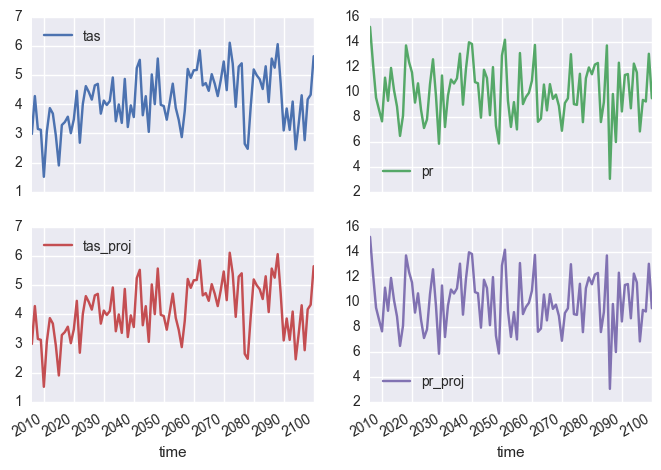

In [16]:
# Compare results
df = df_raw.join(df_proj, rsuffix='_proj')
df.plot(subplots=True, layout=(2, 2))

These results are identical, which is great!

For the "final" data processing, I suspect using something other than nearest-neighbour interpolation will be worthwhile.

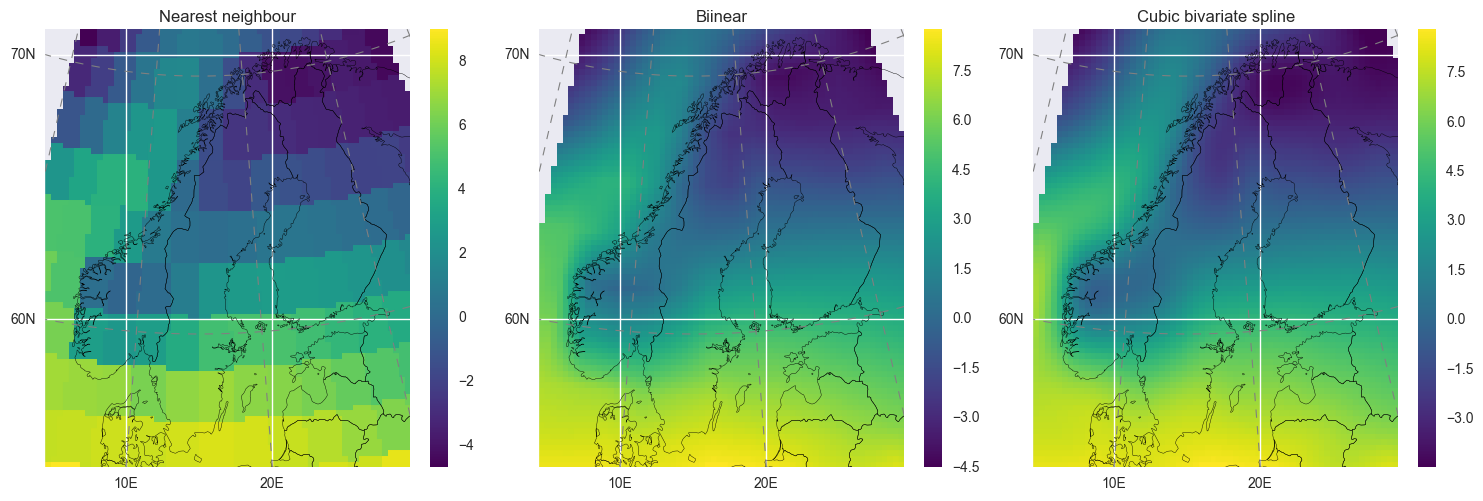

In [17]:
# Setup axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

# Reproject (and clip) to desired output
ds_45_near = gtif.salem.transform(ds_45_agg, interp='nearest')
ds_45_lin = gtif.salem.transform(ds_45_agg, interp='linear')
ds_45_spl = gtif.salem.transform(ds_45_agg, interp='spline')

# Simple map of reprojected data
ds_45_near['tas'][0].salem.quick_map(ax=axes[0])
ds_45_lin['tas'][0].salem.quick_map(ax=axes[1])
ds_45_spl['tas'][0].salem.quick_map(ax=axes[2])

# Labels
axes[0].set_title('Nearest neighbour')
axes[1].set_title('Biinear')
axes[2].set_title('Cubic bivariate spline')

plt.tight_layout()

In this test, nearest neighbour interpolation gives a very blocky result. Linear and spline interpolation are both much better. I can't see much difference between them, so I'll **use linear as it is simpler and less computationally intensive than spline**.

#### 3.1.5. Write results to output

I will write the processed data to a netCDF for easy access and portability, but I also want to write each of the grids to GeoTiff format (for ease of use in ArcGIS).

In [18]:
def array_to_gtiff(xmin, ymax, cell_size, out_path, data_array,
                   proj4_str, no_data_value=-9999):
    """ Save numpy array as GeoTiff (in a projected co-ordinate system).
    
    Args:
        xmin:          Minimum x value in metres
        ymax:          Maximum y value in metres
        cell_size:     Grid cell size in metres
        out_path:      Path to GeoTiff
        data:          Array to save 
        proj4_str      proj.4 string defining the projection
        no_data_value: Value to use to represent no data 
        
    Returns:
        None. Array is saved to specified path.
    """
    # Import modules
    import gdal, gdalconst, osr

    # Explicitly set NDV
    data_array[np.isnan(data_array)] = no_data_value
    
    # Flip. Not sure why this is necessary? Without it the 
    # output grid is upside down! Haven't had this problem before,
    # but this seems to work here. Beware in future!
    #data_array = data_array[::-1,:]

    # Get array shape
    cols = data_array.shape[1]
    rows = data_array.shape[0]

    # Get driver
    driver = gdal.GetDriverByName('GTiff')

    # Create a new raster data source
    out_ds = driver.Create(out_path, cols, rows, 1, gdal.GDT_Float32)

    # Get spatial reference
    sr = osr.SpatialReference()
    sr.ImportFromProj4(proj4_str)
    sr_wkt = sr.ExportToWkt()

    # Write metadata
    # (xmin, cellsize, 0, ymax, 0, -cellsize)
    out_ds.SetGeoTransform((int(xmin), cell_size, 0.0, 
                            int(ymax), 0.0, -cell_size)) 
    out_ds.SetProjection(sr_wkt)
    out_band = out_ds.GetRasterBand(1)
    out_band.SetNoDataValue(-9999)
    out_band.WriteArray(data_array)

    # Tidy up
    del out_ds, out_band

In [19]:
# Write netCDF
out_nc = r'D:\Data\Climate\Annually_Aggregated\rcp45_annual.nc'
ds_45_lin.to_netcdf(out_nc)

# Write grids to geotiff
# Output folder
out_fold = r'D:\Data\Climate\Annually_Aggregated\GeoTiffs\RCP45'

# Loop
for var in ['tas', 'pr']:
    for tm in ds_45_lin['time']:
        # Get year
        year = pd.to_datetime(tm.values).year
        
        # Get data array
        ar = ds_45_lin[var].sel(time=tm).values
        
        # Write to GeoTiff
        out_path = os.path.join(out_fold, 'rcp45_%s_%s.tif' % (var, year))
        array_to_gtiff(325000, 2000000, 25000, out_path, ar,
                       ds_45_lin.salem.grid.proj.srs)

### 3.2. RCP85

#### 3.2.1. Dataset properties

There's something not quite right about the RCP85 data.

In [20]:
# Read all the RC85 files for temp and combine into a single dataset
nc_path = r'D:\Data\Climate\CMIP5\GFDL-ESM2M\Atmos\RCP85\tas\*.nc'
ds_85 = xr.open_mfdataset(nc_path)

# Extract series for lat, lon = 60, 11
ds = ds_85['tas'].sel_points(lon=[11], lat=[60],
                             method='nearest')
df = ds.to_dataframe()
df

tas  height        lat    lon
points time                                                     
0      2006-01-16 12:00:00  267.843658     2.0  59.662921  11.25
       2006-02-15 00:00:00  268.477722     2.0  59.662921  11.25
       2006-03-16 12:00:00  271.432373     2.0  59.662921  11.25
       2006-04-16 00:00:00  271.208893     2.0  59.662921  11.25
       2006-05-16 12:00:00  279.547882     2.0  59.662921  11.25
       2006-06-16 00:00:00  285.692352     2.0  59.662921  11.25
       2006-07-16 12:00:00  287.204620     2.0  59.662921  11.25
       2006-08-16 12:00:00  284.186981     2.0  59.662921  11.25
       2006-09-16 00:00:00  279.482422     2.0  59.662921  11.25
       2006-10-16 12:00:00  277.496643     2.0  59.662921  11.25
       2006-11-16 00:00:00  275.280914     2.0  59.662921  11.25
       2006-12-16 12:00:00  268.381805     2.0  59.662921  11.25
       2007-01-16 12:00:00  269.922729     2.0  59.662921  11.25
       2007-02-15 00:00:00  268.179840     2.0  59.662921  11.25
       2007-03-16 12:00:00  265.753723     2.0  59.662921  11.25
       2007-04-16 00:00:00  269.240723     2.0  59.662921  11.25
       2007-05-16 12:00:00  278.481323     2.0  59.662921  11.25
       2007-06-16 00:00:00  283.492767     2.0  59.662921  11.25
       2007-07-16 12:00:00  286.686096     2.0  59.662921  11.25
       2007-08-16 12:00:00  285.200409     2.0  59.662921  11.25
       2007-09-16 00:00:00  278.669586     2.0  59.662921  11.25
       2007-10-16 12:00:00  276.331665     2.0  59.662921  11.25
       2007-11-16 00:00:00  272.900391     2.0  59.662921  11.25
       2007-12-16 12:00:00  269.182495     2.0  59.662921  11.25
       2008-01-16 12:00:00  267.176849     2.0  59.662921  11.25
       2008-02-15 00:00:00  260.949982     2.0  59.662921  11.25
       2008-03-16 12:00:00  271.135284     2.0  59.662921  11.25
       2008-04-16 00:00:00  270.911591     2.0  59.662921  11.25
       2008-05-16 12:00:00  278.737274     2.0  59.662921  11.25
       2008-06-16 00:00:00  286.097687     2.0  59.662921  11.25
...                                ...     ...        ...    ...
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
       2006-01-01 00:00:00    0.000000     2.0  59.662921  11.25
     

Note that everything starts OK, but the last dates in the series (which should be for the 2090s) are incorrectly labelled as being from 2006 (and all the temperature values are 0 anyway). This does not bode well for anyone that's used this data previously!

The full time series is saved here in Excel format to make the issue clearer:

C:\workspace\JES\domqua_climate_proc\rcp85_duplicated_temp_time_index.xlsx

**For now I will ignore RCP85**.

## 4. Historic data

### 4.1. Dataset properties

In [21]:
# Read all the historic files and combine into a single dataset
nc_path = r'D:\Data\Climate\E-OBS\Data\*.nc'
ds_obs = xr.open_mfdataset(nc_path)

# Get variable info without reading whole dataset
ds_obs.variables

Frozen(OrderedDict([(u'longitude', <xarray.IndexVariable u'longitude' (longitude: 464)>
array([-40.375, -40.125, -39.875, ...,  74.875,  75.125,  75.375], dtype=float32)
Attributes:
    long_name: Longitude values
    units: degrees_east
    standard_name: longitude), (u'latitude', <xarray.IndexVariable u'latitude' (latitude: 201)>
array([ 25.375,  25.625,  25.875, ...,  74.875,  75.125,  75.375], dtype=float32)
Attributes:
    long_name: Latitude values
    units: degrees_north
    standard_name: latitude), (u'time', <xarray.IndexVariable u'time' (time: 24106)>
array(['1950-01-01T00:00:00.000000000', '1950-01-02T00:00:00.000000000',
       '1950-01-03T00:00:00.000000000', ..., '2015-12-29T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name: Time in days
    standard_name: time), (u'rr', <xarray.Variable (time: 24106, latitude: 201, longitude: 464)>
dask.array<D:\Data..., shape=(24106, 201, 464

So it looks as though we have a **precipitation variable called `rr` in mm** and a **temperature variable called `tg` in C**.

### 4.2. Resampling

For some reason I'm having trouble working with the combined file. Try processing them separately and then combining them at the end instead.

In [22]:
# Read historic temp data
nc_path = r'D:\Data\Climate\E-OBS\Data\tg_0.25deg_reg_v13.1.nc'
ds_obst = xr.open_dataset(nc_path)

# Calculate mean annual temperature
ds_obst = ds_obst['tg'].resample(freq='A',
                                 dim='time', 
                                 how='mean')

# Read historic pptn data
nc_path = r'D:\Data\Climate\E-OBS\Data\rr_0.25deg_reg_v13.1.nc'
ds_obsp = xr.open_dataset(nc_path)

# Calculate quarterly total pptn
ds_obsp = ds_obsp['rr'].resample(freq='Q-MAR',
                                 dim='time', 
                                 how='sum')

# Select just the grids where month = 9 (JAS)
ds_obsp = ds_obsp[ds_obsp['time.month']==9]

# Resample this to annual (as we no longer need the month info)
# NB. This will still give just the summer totals in each year
ds_obsp = ds_obsp.resample(freq='A',
                           dim='time', 
                           how='mean')

# Combine temp and pptn
ds_obs = xr.merge([ds_obst, ds_obsp])

ds_obs

<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 66)
Coordinates:
  * longitude  (longitude) float32 -40.375 -40.125 -39.875 -39.625 -39.375 ...
  * latitude   (latitude) float32 25.375 25.625 25.875 26.125 26.375 26.625 ...
  * time       (time) datetime64[ns] 1950-12-31 1951-12-31 1952-12-31 ...
Data variables:
    tg         (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    rr         (time, latitude, longitude) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...

### 4.3. Reprojecting, clipping and resampling

The first thing to test is whether Salem can correctly infer the projection parameters for this dataset.

+units=m +datum=WGS84 +proj=latlong 
[-40.5, 75.5, 25.25, 75.5]


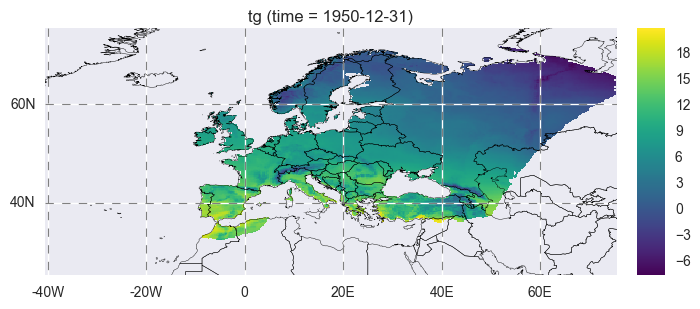

In [23]:
# Print proj pars guessed by Salem
grid = ds_obs.salem.grid

print grid.proj.srs
print grid.extent

# Simple map
ds_obs['tg'][0].salem.quick_map()

This looks much more reasonable. I think the issue with the future climate data (above) was probably due to a dateline discontinuity. In the E-Obs dataset, longitudes are numbered sequentially from -180 degrees (the international dateline) to +180, which means that (unlike with the future climate data) there are no discontinuities within Europe. For this reason, everything seems to be working OK here.

In [24]:
# Reproject (and clip) to desired output
ds_obs_proj = gtif.salem.transform(ds_obs, interp='linear')
ds_obs_proj

<xarray.Dataset>
Dimensions:  (time: 66, x: 64, y: 77)
Coordinates:
  * y        (y) float64 1.988e+06 1.962e+06 1.938e+06 1.912e+06 1.888e+06 ...
  * x        (x) float64 3.375e+05 3.625e+05 3.875e+05 4.125e+05 4.375e+05 ...
  * time     (time) datetime64[ns] 1950-12-31 1951-12-31 1952-12-31 ...
Data variables:
    tg       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    rr       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    pyproj_srs: +lon_0=15 +ellps=WGS84 +y_0=1000000 +no_defs=True +proj=aea +x_0=1000000 +units=m +lat_2=73 +lat_1=53 +lat_0=63 

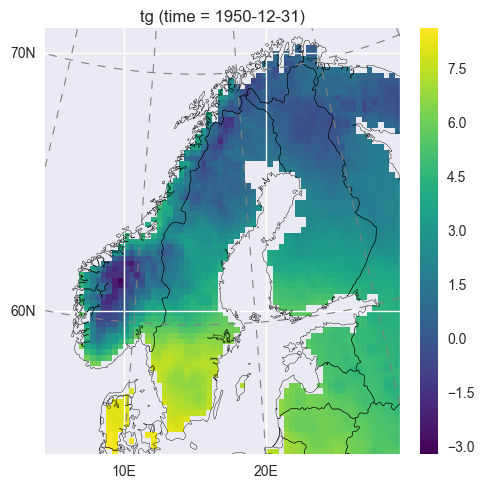

In [25]:
# Simple map of reprojected data
ds_obs_proj['tg'][0].salem.quick_map()

This seems to have worked well. However, **note that the observed data is coarsely constrained to be within the coastline (unlike the future climate data)**. There are therefore many more "no data" cells in this dataset. This will need to be borne in mind when performing calculations involving both the historic and future outputs.

### 4.4. Write results to output

In [26]:
# Write netCDF
out_nc = r'D:\Data\Climate\Annually_Aggregated\e-obs_annual.nc'
ds_obs_proj.to_netcdf(out_nc)

# Write grids to geotiff
# Output folder
out_fold = r'D:\Data\Climate\Annually_Aggregated\GeoTiffs\E-Obs'

# Loop
for var in ['tg', 'rr']:
    for tm in ds_obs_proj['time']:
        # Get year
        year = pd.to_datetime(tm.values).year
        
        # Get data array
        ar = ds_obs_proj[var].sel(time=tm).values
        
        # Write to GeoTiff
        out_path = os.path.join(out_fold, 'eobs_%s_%s.tif' % (var, year))
        array_to_gtiff(325000, 2000000, 25000, out_path, ar,
                       ds_obs_proj.salem.grid.proj.srs)